In [1]:
"""
Reader Script for LiH QML Comparison Results (4 Methods)

Loads data saved by run_comparison_four_methods.py and generates plots/analysis.

Methods:
1. Rotationally Equivariant QML (SO(3) symmetry)
2. Non-Equivariant QML (baseline)
3. Graph Permutation Equivariant QML (permutation symmetry)
4. Classical Rotationally Equivariant NN (E(3) invariant MLP)

Usage:
    python read_results.py <results_dir>
    python read_results.py results --plot all --save figures/
    
    or as module:
    from read_results import ResultsReader
    reader = ResultsReader("results")
    reader.plot_comparison()
"""

import numpy as np
import json
import os
import matplotlib.pyplot as plt
import argparse


class ResultsReader:
    """Reader for LiH QML comparison results (4 methods)."""
    
    # Method configuration
    METHODS = [
        "rotationally_equivariant",
        "non_equivariant", 
        "graph_permutation_equivariant",
        "classical_equivariant"
    ]
    
    METHOD_LABELS = {
        "rotationally_equivariant": "Rot. Equiv. QML",
        "non_equivariant": "Non-Equiv. QML",
        "graph_permutation_equivariant": "Graph Perm. QML",
        "classical_equivariant": "Classical Equiv. NN"
    }
    
    METHOD_COLORS = {
        "rotationally_equivariant": "#2ecc71",  # Green
        "non_equivariant": "#e74c3c",            # Red
        "graph_permutation_equivariant": "#3498db",  # Blue
        "classical_equivariant": "#9b59b6"       # Purple
    }
    
    def __init__(self, results_dir):
        """Load results from directory."""
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_data()
        self._detect_methods()
    
    def _load_data(self):
        """Load all data files."""
        print(f"Loading results from: {self.results_dir}")
        
        # Load JSON results
        json_path = os.path.join(self.results_dir, "results.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                self.results = json.load(f)
            print(f"  ✓ Loaded results.json")
        
        # Load numpy metrics
        npz_path = os.path.join(self.results_dir, "metrics.npz")
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"  ✓ Loaded metrics.npz")
    
    def _detect_methods(self):
        """Detect which methods are present in results."""
        if not self.results:
            self.available_methods = []
            return
        
        self.available_methods = []
        for method in self.METHODS:
            if method in self.results and self.results[method].get("runs"):
                self.available_methods.append(method)
        
        # Fallback for older 2-method format
        if not self.available_methods:
            if "equivariant" in self.results:
                self.available_methods = ["equivariant", "non_equivariant"]
                self.METHOD_LABELS["equivariant"] = "Equivariant"
                self.METHOD_COLORS["equivariant"] = "#2ecc71"
        
        print(f"  ✓ Detected {len(self.available_methods)} methods: {self.available_methods}")
    
    def print_summary(self):
        """Print summary statistics."""
        if not self.results:
            print("No results loaded")
            return
        
        config = self.results.get("config", {})
        
        print("\n" + "="*100)
        print("EXPERIMENT SUMMARY")
        print("="*100)
        print(f"Runs: {config.get('n_runs', 'N/A')}")
        print(f"Epochs: {config.get('n_epochs', 'N/A')}")
        print(f"Timestamp: {config.get('timestamp', 'N/A')}")
        
        # Build header
        n_methods = len(self.available_methods)
        col_width = 18
        
        print("\n" + "-"*100)
        header = f"{'Metric':<15}"
        for method in self.available_methods:
            header += f"{self.METHOD_LABELS.get(method, method):<{col_width}}"
        print(header)
        print("-"*100)
        
        metrics_to_show = ["E_r2", "E_mae_Ha", "E_rmse_Ha", "F_r2", "F_mae", "F_rmse"]
        
        for metric in metrics_to_show:
            row = f"{metric:<15}"
            for method in self.available_methods:
                summary = self.results[method]["metrics_summary"].get(metric, {})
                mean = summary.get('mean', 0)
                std = summary.get('std', 0)
                row += f"{mean:.4f}±{std:.4f}    "
            print(row)
        
        print("="*100)
    
    def plot_comparison_bars(self, save_path=None, show=True):
        """Create bar chart comparing all methods for R² scores."""
        if not self.results:
            print("No results loaded")
            return None
        
        metrics = ["E_r2", "F_r2"]
        labels = ["Energy R²", "Force R²"]
        
        n_methods = len(self.available_methods)
        n_metrics = len(metrics)
        
        # Collect data
        data = {method: {"means": [], "stds": []} for method in self.available_methods}
        
        for m in metrics:
            for method in self.available_methods:
                summary = self.results[method]["metrics_summary"][m]
                data[method]["means"].append(summary["mean"])
                data[method]["stds"].append(summary["std"])
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(n_metrics)
        width = 0.8 / n_methods
        
        for i, method in enumerate(self.available_methods):
            offset = (i - n_methods/2 + 0.5) * width
            bars = ax.bar(x + offset, data[method]["means"], width,
                         yerr=data[method]["stds"],
                         label=self.METHOD_LABELS.get(method, method),
                         color=self.METHOD_COLORS.get(method, f'C{i}'),
                         capsize=4, alpha=0.8)
            
            # Add value labels
            for bar, val in zip(bars, data[method]["means"]):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)
        
        ax.set_ylabel('R² Score', fontsize=12)
        ax.set_title('LiH Energy/Force Prediction: Method Comparison', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)
        ax.legend(fontsize=10, loc='upper right')
        ax.set_ylim([0, 1.15])
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_mae_comparison(self, save_path=None, show=True):
        """Create bar chart for MAE comparison."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        n_methods = len(self.available_methods)
        x = np.arange(n_methods)
        
        # Energy MAE
        ax = axes[0]
        means = []
        stds = []
        colors = []
        for method in self.available_methods:
            summary = self.results[method]["metrics_summary"]["E_mae_Ha"]
            means.append(summary["mean"] * 1000)  # Convert to mHa
            stds.append(summary["std"] * 1000)
            colors.append(self.METHOD_COLORS.get(method, 'gray'))
        
        bars = ax.bar(x, means, yerr=stds, color=colors, capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS.get(m, m) for m in self.available_methods],
                          fontsize=9, rotation=15, ha='right')
        ax.set_ylabel('MAE (mHa)', fontsize=12)
        ax.set_title('Energy MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, val in zip(bars, means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{val:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Force MAE
        ax = axes[1]
        means = []
        stds = []
        colors = []
        for method in self.available_methods:
            summary = self.results[method]["metrics_summary"]["F_mae"]
            means.append(summary["mean"])
            stds.append(summary["std"])
            colors.append(self.METHOD_COLORS.get(method, 'gray'))
        
        bars = ax.bar(x, means, yerr=stds, color=colors, capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS.get(m, m) for m in self.available_methods],
                          fontsize=9, rotation=15, ha='right')
        ax.set_ylabel('MAE (eV/Å)', fontsize=12)
        ax.set_title('Force MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, val in zip(bars, means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_training_curves(self, save_path=None, show=True):
        """Plot training loss curves for all methods."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for method in self.available_methods:
            runs = self.results[method]["runs"]
            color = self.METHOD_COLORS.get(method, 'gray')
            label = self.METHOD_LABELS.get(method, method)
            
            # Collect all training curves
            all_E_loss = []
            all_F_loss = []
            epochs = None
            
            for run in runs:
                history = run.get("history", {})
                if history.get("epoch"):
                    epochs = history["epoch"]
                    all_E_loss.append(history.get("test_E_loss", []))
                    all_F_loss.append(history.get("test_F_loss", []))
            
            if not epochs or not all_E_loss:
                continue
            
            # Average across runs
            min_len = min(len(h) for h in all_E_loss)
            all_E_loss = [h[:min_len] for h in all_E_loss]
            all_F_loss = [h[:min_len] for h in all_F_loss]
            epochs = epochs[:min_len]
            
            mean_E = np.mean(all_E_loss, axis=0)
            std_E = np.std(all_E_loss, axis=0)
            mean_F = np.mean(all_F_loss, axis=0)
            std_F = np.std(all_F_loss, axis=0)
            
            # Energy loss
            axes[0].plot(epochs, mean_E, color=color, label=label, linewidth=2)
            axes[0].fill_between(epochs, mean_E - std_E, mean_E + std_E,
                                color=color, alpha=0.15)
            
            # Force loss
            axes[1].plot(epochs, mean_F, color=color, label=label, linewidth=2)
            axes[1].fill_between(epochs, mean_F - std_F, mean_F + std_F,
                                color=color, alpha=0.15)
        
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Test Energy Loss (MSE)', fontsize=12)
        axes[0].set_title('Energy Training Progress', fontsize=14)
        axes[0].legend(fontsize=9)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_yscale('log')
        
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Test Force Loss (MSE)', fontsize=12)
        axes[1].set_title('Force Training Progress', fontsize=14)
        axes[1].legend(fontsize=9)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_predictions(self, run_idx=0, save_path=None, show=True):
        """Plot predicted vs true values for all methods."""
        if not self.results:
            return None
        
        n_methods = len(self.available_methods)
        fig, axes = plt.subplots(2, n_methods, figsize=(4*n_methods, 8))
        
        # Handle single method case
        if n_methods == 1:
            axes = axes.reshape(2, 1)
        
        for col, method in enumerate(self.available_methods):
            runs = self.results[method]["runs"]
            if run_idx >= len(runs):
                continue
                
            run = runs[run_idx]
            preds = run.get("predictions", {})
            metrics = run.get("metrics", {})
            
            if not preds:
                continue
            
            E_pred = np.array(preds["E_pred"])
            E_true = np.array(preds["E_true"])
            F_pred = np.array(preds["F_pred"])
            F_true = np.array(preds["F_true"])
            test_idx = preds["indices_test"]
            
            E_pred_test = E_pred[test_idx]
            E_true_test = E_true[test_idx]
            F_pred_test = F_pred[test_idx]
            F_true_test = F_true[test_idx]
            
            color = self.METHOD_COLORS.get(method, 'gray')
            title = self.METHOD_LABELS.get(method, method)
            
            # Energy scatter
            ax = axes[0, col]
            ax.scatter(E_true_test, E_pred_test, alpha=0.6, color=color, s=25)
            lims = [min(E_true_test.min(), E_pred_test.min()), 
                   max(E_true_test.max(), E_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Energy (Ha)', fontsize=10)
            ax.set_ylabel('Predicted Energy (Ha)', fontsize=10)
            E_r2 = metrics.get("E_r2", 0)
            ax.set_title(f'{title}\nEnergy R²={E_r2:.3f}', fontsize=11)
            ax.grid(True, alpha=0.3)
            
            # Force scatter
            ax = axes[1, col]
            ax.scatter(F_true_test, F_pred_test, alpha=0.6, color=color, s=25)
            lims = [min(F_true_test.min(), F_pred_test.min()),
                   max(F_true_test.max(), F_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Force Z (eV/Å)', fontsize=10)
            ax.set_ylabel('Predicted Force Z (eV/Å)', fontsize=10)
            F_r2 = metrics.get("F_r2", 0)
            ax.set_title(f'{title}\nForce R²={F_r2:.3f}', fontsize=11)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_summary(self, save_path=None, show=True):
        """Create a comprehensive summary plot comparing all methods."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        n_methods = len(self.available_methods)
        x = np.arange(n_methods)
        
        # ===== Plot 1: Energy vs Force R² grouped bar chart =====
        ax = axes[0, 0]
        width = 0.35
        
        E_r2 = [self.results[m]["metrics_summary"]["E_r2"]["mean"] for m in self.available_methods]
        F_r2 = [self.results[m]["metrics_summary"]["F_r2"]["mean"] for m in self.available_methods]
        E_r2_err = [self.results[m]["metrics_summary"]["E_r2"]["std"] for m in self.available_methods]
        F_r2_err = [self.results[m]["metrics_summary"]["F_r2"]["std"] for m in self.available_methods]
        
        bars1 = ax.bar(x - width/2, E_r2, width, yerr=E_r2_err, label='Energy R²',
                      color='steelblue', alpha=0.8, capsize=4)
        bars2 = ax.bar(x + width/2, F_r2, width, yerr=F_r2_err, label='Force R²',
                      color='coral', alpha=0.8, capsize=4)
        
        ax.set_ylabel('R² Score', fontsize=11)
        ax.set_title('Energy vs Force Prediction Performance', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS.get(m, m) for m in self.available_methods],
                          fontsize=9, rotation=10, ha='right')
        ax.legend(fontsize=9)
        ax.set_ylim([0, 1.15])
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width()/2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        # ===== Plot 2: MAE comparison =====
        ax = axes[0, 1]
        
        E_mae = [self.results[m]["metrics_summary"]["E_mae_Ha"]["mean"] * 1000 for m in self.available_methods]
        F_mae = [self.results[m]["metrics_summary"]["F_mae"]["mean"] for m in self.available_methods]
        
        colors = [self.METHOD_COLORS.get(m, 'gray') for m in self.available_methods]
        
        # Normalize for comparison (different scales)
        bars = ax.bar(x - width/2, E_mae, width, color=colors, alpha=0.6, label='Energy MAE (mHa)')
        bars2 = ax.bar(x + width/2, F_mae, width, color=colors, alpha=1.0, hatch='//', label='Force MAE (eV/Å)')
        
        ax.set_ylabel('MAE', fontsize=11)
        ax.set_title('Mean Absolute Errors', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS.get(m, m) for m in self.available_methods],
                          fontsize=9, rotation=10, ha='right')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # ===== Plot 3: Training curves (Energy) =====
        ax = axes[1, 0]
        
        for method in self.available_methods:
            runs = self.results[method]["runs"]
            color = self.METHOD_COLORS.get(method, 'gray')
            label = self.METHOD_LABELS.get(method, method)
            
            all_E_loss = []
            epochs = None
            
            for run in runs:
                history = run.get("history", {})
                if history.get("epoch"):
                    epochs = history["epoch"]
                    all_E_loss.append(history.get("test_E_loss", []))
            
            if not epochs or not all_E_loss:
                continue
            
            min_len = min(len(h) for h in all_E_loss)
            all_E_loss = [h[:min_len] for h in all_E_loss]
            epochs = epochs[:min_len]
            
            mean_E = np.mean(all_E_loss, axis=0)
            ax.plot(epochs, mean_E, color=color, label=label, linewidth=2)
        
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Test Energy Loss (MSE)', fontsize=11)
        ax.set_title('Energy Training Progress', fontsize=12)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        # ===== Plot 4: Training curves (Force) =====
        ax = axes[1, 1]
        
        for method in self.available_methods:
            runs = self.results[method]["runs"]
            color = self.METHOD_COLORS.get(method, 'gray')
            label = self.METHOD_LABELS.get(method, method)
            
            all_F_loss = []
            epochs = None
            
            for run in runs:
                history = run.get("history", {})
                if history.get("epoch"):
                    epochs = history["epoch"]
                    all_F_loss.append(history.get("test_F_loss", []))
            
            if not epochs or not all_F_loss:
                continue
            
            min_len = min(len(h) for h in all_F_loss)
            all_F_loss = [h[:min_len] for h in all_F_loss]
            epochs = epochs[:min_len]
            
            mean_F = np.mean(all_F_loss, axis=0)
            ax.plot(epochs, mean_F, color=color, label=label, linewidth=2)
        
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Test Force Loss (MSE)', fontsize=11)
        ax.set_title('Force Training Progress', fontsize=12)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_radar(self, save_path=None, show=True):
        """Create radar/spider chart comparing all methods across metrics."""
        if not self.results:
            return None
        
        # Metrics to compare (normalize to 0-1 scale where higher is better)
        metrics_config = {
            "E_r2": {"label": "Energy R²", "higher_better": True},
            "F_r2": {"label": "Force R²", "higher_better": True},
            "E_mae_Ha": {"label": "Energy MAE", "higher_better": False},
            "F_mae": {"label": "Force MAE", "higher_better": False},
        }
        
        # Collect values
        values = {m: [] for m in self.available_methods}
        
        for metric, config in metrics_config.items():
            all_vals = []
            for method in self.available_methods:
                val = self.results[method]["metrics_summary"][metric]["mean"]
                all_vals.append(val)
            
            # Normalize
            min_val, max_val = min(all_vals), max(all_vals)
            range_val = max_val - min_val if max_val != min_val else 1
            
            for i, method in enumerate(self.available_methods):
                normalized = (all_vals[i] - min_val) / range_val
                if not config["higher_better"]:
                    normalized = 1 - normalized  # Invert so higher is always better
                values[method].append(normalized)
        
        # Create radar chart
        labels = [config["label"] for config in metrics_config.values()]
        num_vars = len(labels)
        
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the loop
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        for method in self.available_methods:
            vals = values[method] + values[method][:1]  # Complete the loop
            color = self.METHOD_COLORS.get(method, 'gray')
            label = self.METHOD_LABELS.get(method, method)
            
            ax.plot(angles, vals, 'o-', linewidth=2, label=label, color=color)
            ax.fill(angles, vals, alpha=0.15, color=color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10)
        ax.set_ylim(0, 1)
        ax.set_title('Method Comparison (Normalized Metrics)', fontsize=14, pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        plots = {
            "comparison_r2.png": self.plot_comparison_bars,
            "comparison_mae.png": self.plot_mae_comparison,
            "training_curves.png": self.plot_training_curves,
            "predictions.png": self.plot_predictions,
            "summary.png": self.plot_summary,
            "radar.png": self.plot_radar,
        }
        
        for filename, plot_func in plots.items():
            save_path = os.path.join(output_dir, filename) if output_dir else None
            try:
                plot_func(save_path=save_path, show=show)
            except Exception as e:
                print(f"Warning: Could not generate {filename}: {e}")
    
    def export_csv(self, output_path):
        """Export summary to CSV."""
        if not self.results:
            return
        
        lines = ["Model,Metric,Mean,Std,Min,Max"]
        
        for method in self.available_methods:
            summary = self.results[method]["metrics_summary"]
            label = self.METHOD_LABELS.get(method, method)
            for metric, stats in summary.items():
                line = f"{label},{metric},{stats['mean']:.6f},{stats['std']:.6f},"
                line += f"{stats['min']:.6f},{stats['max']:.6f}"
                lines.append(line)
        
        with open(output_path, 'w') as f:
            f.write('\n'.join(lines))
        
        print(f"CSV exported: {output_path}")
    
    def export_latex_table(self, output_path=None):
        """Export results as LaTeX table."""
        if not self.results:
            return None
        
        metrics = ["E_r2", "E_mae_Ha", "F_r2", "F_mae"]
        metric_labels = {
            "E_r2": "Energy $R^2$",
            "E_mae_Ha": "Energy MAE (Ha)",
            "F_r2": "Force $R^2$",
            "F_mae": "Force MAE (eV/\\AA)"
        }
        
        lines = [
            "\\begin{table}[h]",
            "\\centering",
            "\\caption{LiH Energy/Force Prediction: Method Comparison}",
            "\\label{tab:comparison}",
            "\\begin{tabular}{l" + "c" * len(self.available_methods) + "}",
            "\\toprule",
        ]
        
        # Header
        header = "Metric"
        for method in self.available_methods:
            header += f" & {self.METHOD_LABELS.get(method, method)}"
        header += " \\\\"
        lines.append(header)
        lines.append("\\midrule")
        
        # Data rows
        for metric in metrics:
            row = metric_labels.get(metric, metric)
            for method in self.available_methods:
                summary = self.results[method]["metrics_summary"][metric]
                row += f" & ${summary['mean']:.4f} \\pm {summary['std']:.4f}$"
            row += " \\\\"
            lines.append(row)
        
        lines.extend([
            "\\bottomrule",
            "\\end{tabular}",
            "\\end{table}"
        ])
        
        latex_str = '\n'.join(lines)
        
        if output_path:
            with open(output_path, 'w') as f:
                f.write(latex_str)
            print(f"LaTeX table exported: {output_path}")
        
        return latex_str
    
    def get_metric(self, method, metric_name):
        """Get specific metric values."""
        if not self.results:
            return None
        if method not in self.results:
            return None
        return self.results[method]["metrics_summary"].get(metric_name, {})
    
    def get_best_method(self, metric="E_r2", higher_better=True):
        """Find the best performing method for a given metric."""
        if not self.results:
            return None
        
        best_method = None
        best_value = None
        
        for method in self.available_methods:
            val = self.results[method]["metrics_summary"][metric]["mean"]
            if best_value is None:
                best_value = val
                best_method = method
            elif higher_better and val > best_value:
                best_value = val
                best_method = method
            elif not higher_better and val < best_value:
                best_value = val
                best_method = method
        
        return {
            "method": best_method,
            "label": self.METHOD_LABELS.get(best_method, best_method),
            "value": best_value
        }


def main(results_dir, plot='all', save_dir=None, csv=None, latex=None, show=True):
    """
    Main function - can be called directly from Jupyter or command line.
    
    Args:
        results_dir: Directory containing results
        plot: Type of plot ('comparison', 'mae', 'training', 'predictions', 'summary', 'radar', 'all')
        save_dir: Directory to save plots (optional)
        csv: Path to export CSV (optional)
        latex: Path to export LaTeX table (optional)
        show: Whether to display plots
    
    Returns:
        ResultsReader object
    """
    reader = ResultsReader(results_dir)
    reader.print_summary()
    
    # Print best methods
    print("\nBest Methods:")
    for metric, higher in [("E_r2", True), ("F_r2", True), ("E_mae_Ha", False), ("F_mae", False)]:
        best = reader.get_best_method(metric, higher)
        if best:
            print(f"  {metric}: {best['label']} ({best['value']:.4f})")
    
    if csv:
        reader.export_csv(csv)
    
    if latex:
        reader.export_latex_table(latex)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    plot_funcs = {
        'comparison': ('comparison_r2.png', reader.plot_comparison_bars),
        'mae': ('comparison_mae.png', reader.plot_mae_comparison),
        'training': ('training_curves.png', reader.plot_training_curves),
        'predictions': ('predictions.png', reader.plot_predictions),
        'summary': ('summary.png', reader.plot_summary),
        'radar': ('radar.png', reader.plot_radar),
    }
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot in plot_funcs:
        filename, func = plot_funcs[plot]
        path = os.path.join(save_dir, filename) if save_dir else None
        func(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter notebook. Call main() directly with parameters:")
        print("  reader = main('lih_results', plot='all', save_dir='figures', show=True)")
        print("\nOr use the ResultsReader class directly:")
        print("  reader = ResultsReader('lih_results')")
        print("  reader.print_summary()")
        print("  reader.plot_comparison_bars()")
        print("  reader.plot_summary()")
        print("  reader.plot_radar()")
        print("  reader.export_latex_table('table.tex')")
    else:
        parser = argparse.ArgumentParser(description="Read and analyze LiH QML comparison results (4 methods)")
        parser.add_argument("results_dir", help="Directory containing results")
        parser.add_argument("--plot", choices=['comparison', 'mae', 'training', 'predictions', 'summary', 'radar', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--latex", type=str, help="Export to LaTeX table")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            latex=args.latex,
            show=not args.no_show
        )

Running in Jupyter notebook. Call main() directly with parameters:
  reader = main('lih_results', plot='all', save_dir='figures', show=True)

Or use the ResultsReader class directly:
  reader = ResultsReader('lih_results')
  reader.print_summary()
  reader.plot_comparison_bars()
  reader.plot_summary()
  reader.plot_radar()
  reader.export_latex_table('table.tex')


Loading results from: lih_results
  ✓ Loaded results.json
  ✓ Loaded metrics.npz
  ✓ Detected 4 methods: ['rotationally_equivariant', 'non_equivariant', 'graph_permutation_equivariant', 'classical_equivariant']

EXPERIMENT SUMMARY
Runs: 1
Epochs: 200
Timestamp: 2025-12-03T21:13:18.030661

----------------------------------------------------------------------------------------------------
Metric         Rot. Equiv. QML   Non-Equiv. QML    Graph Perm. QML   Classical Equiv. NN
----------------------------------------------------------------------------------------------------
E_r2           0.9963±0.0000    0.9979±0.0000    0.9964±0.0000    0.9978±0.0000    
E_mae_Ha       0.0278±0.0000    0.0262±0.0000    0.0332±0.0000    0.0233±0.0000    
E_rmse_Ha      0.0394±0.0000    0.0300±0.0000    0.0388±0.0000    0.0307±0.0000    
F_r2           0.9937±0.0000    0.9584±0.0000    0.9548±0.0000    0.9930±0.0000    
F_mae          0.8454±0.0000    2.5130±0.0000    2.5839±0.0000    0.9685±0.0000    

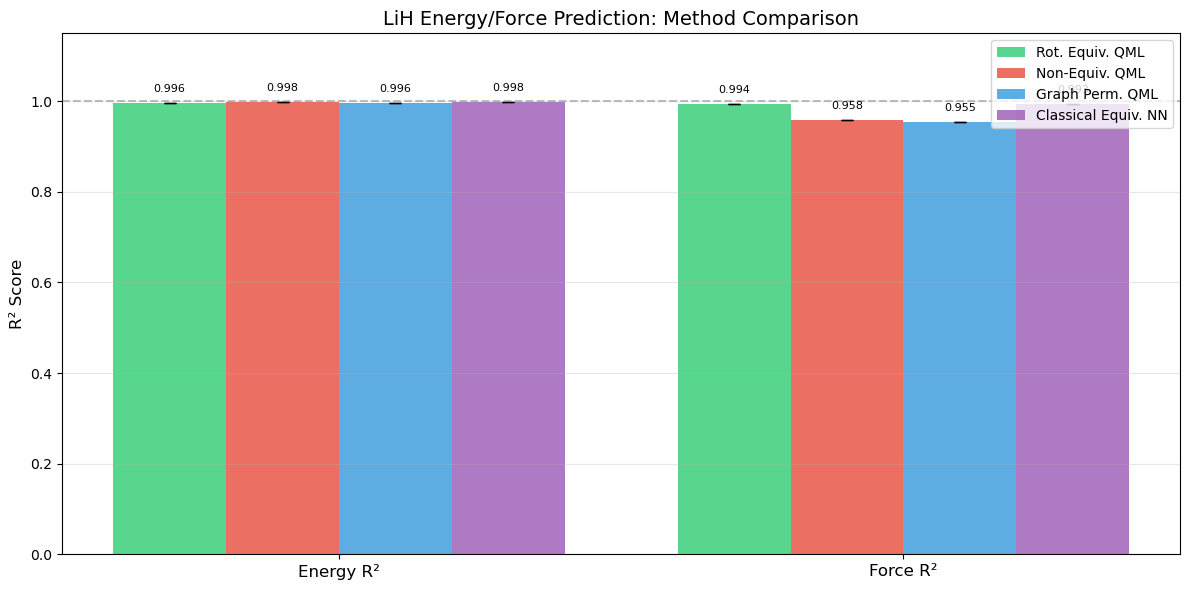

Saved: figures/LiH/comparison_mae.png


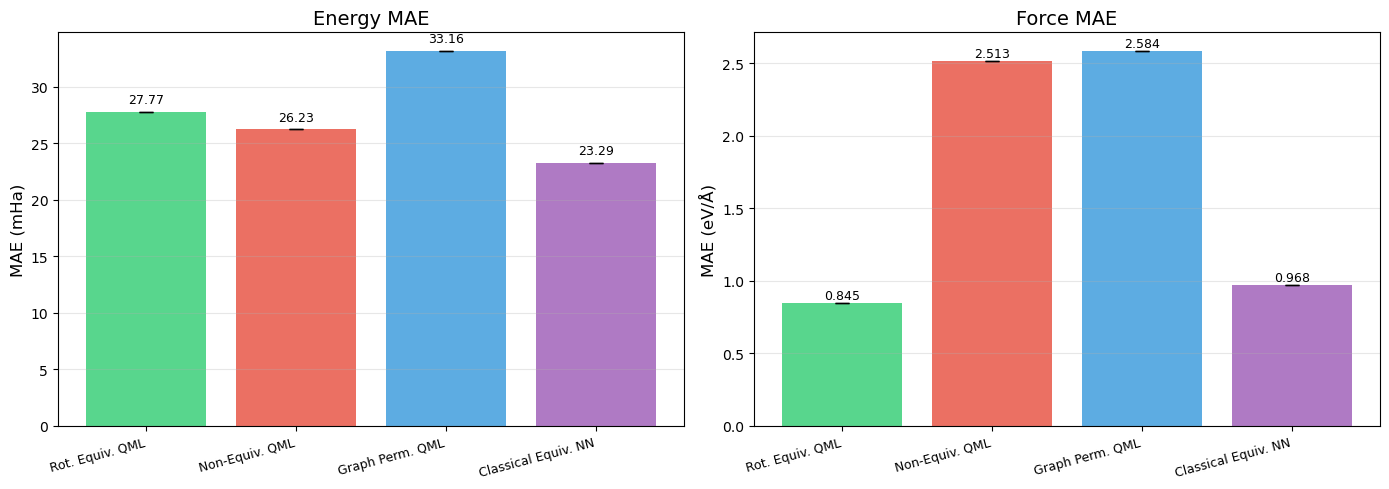

Saved: figures/LiH/training_curves.png


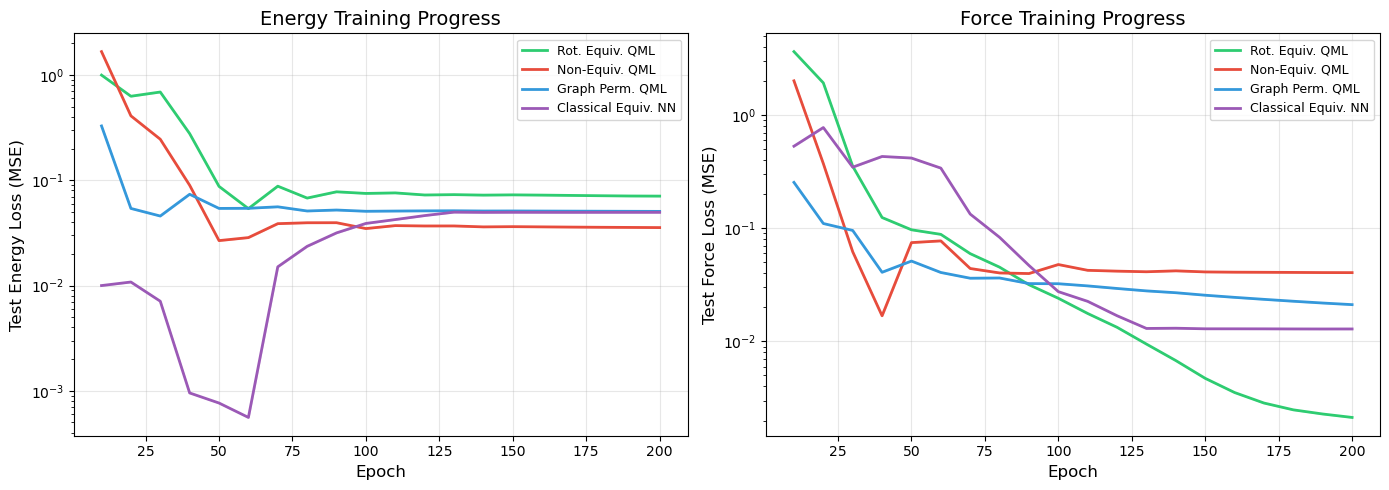

Saved: figures/LiH/predictions.png


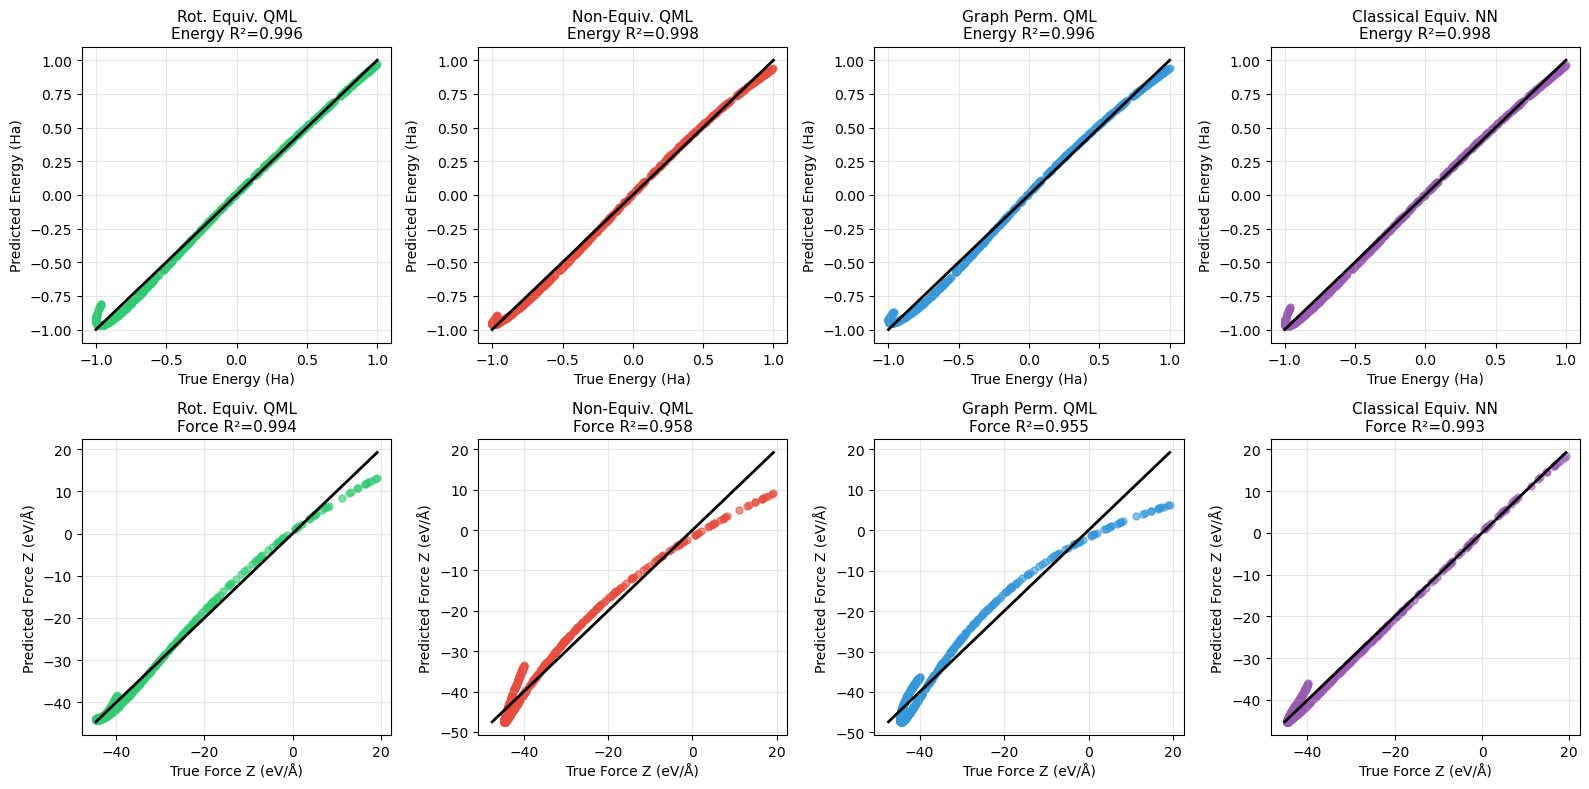

Saved: figures/LiH/summary.png


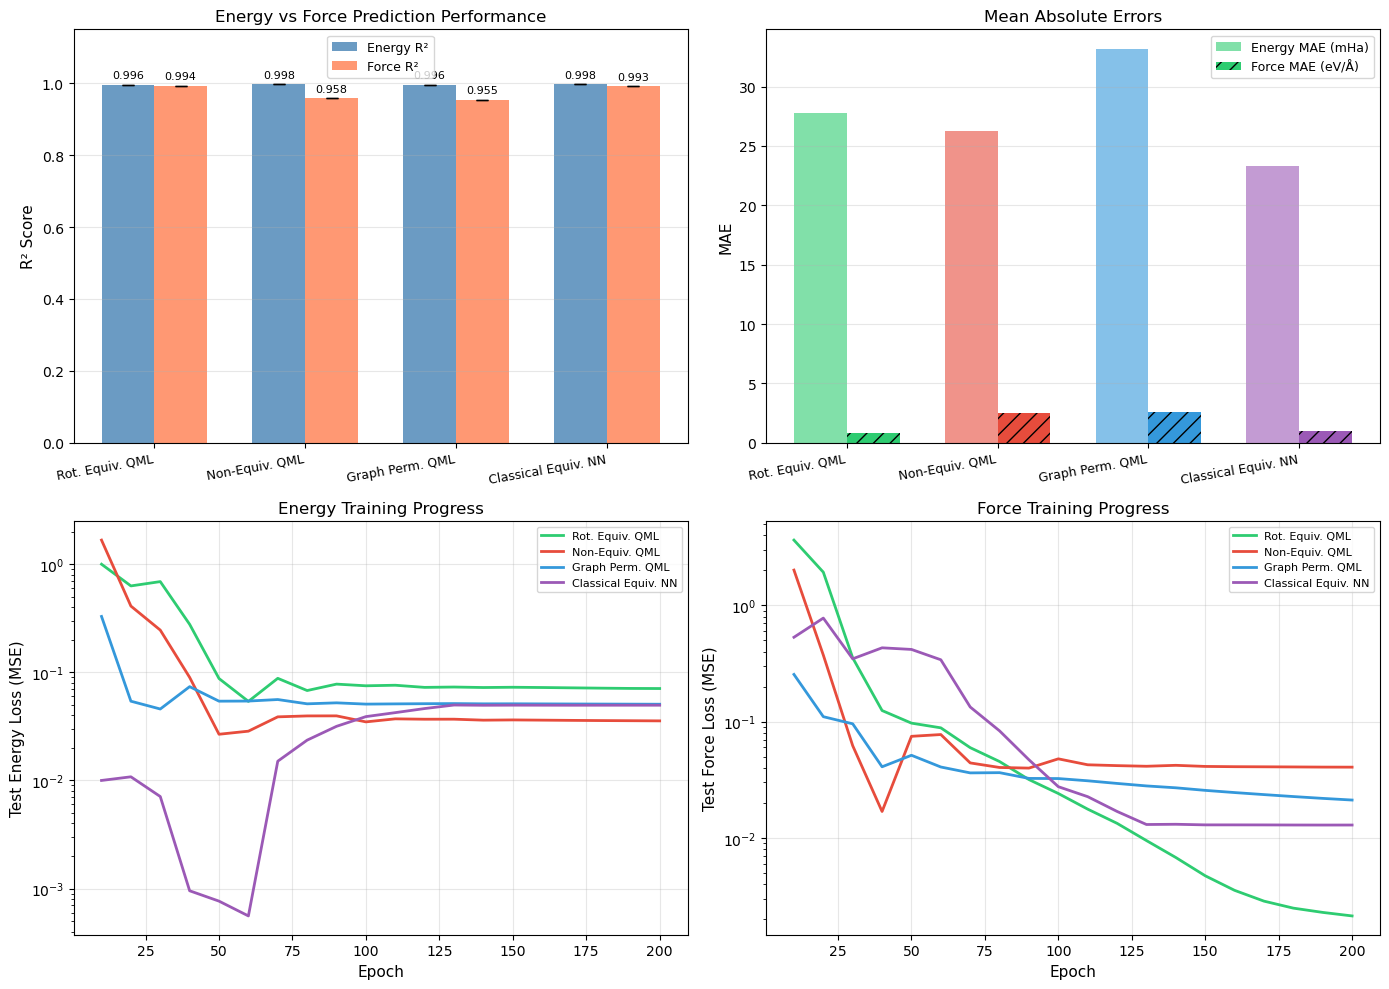

Saved: figures/LiH/radar.png


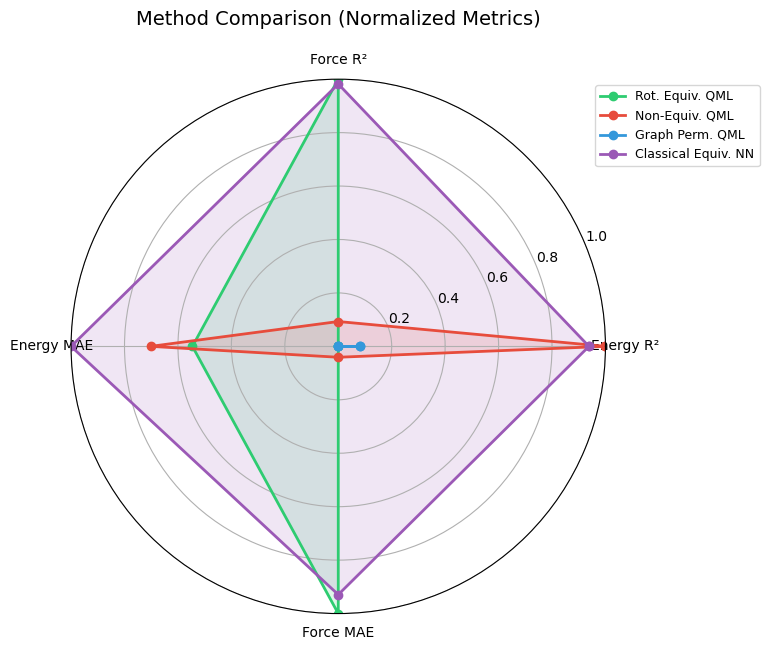

In [3]:
reader = main('lih_results', plot='all', save_dir='figures/LiH/', show=True)